In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 2  # numer of node visits in a trajectory
num_desired_trajectories= 20

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.gen_dataset(fixed_start=True)
test_dataset = env.gen_dataset(fixed_start=True)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

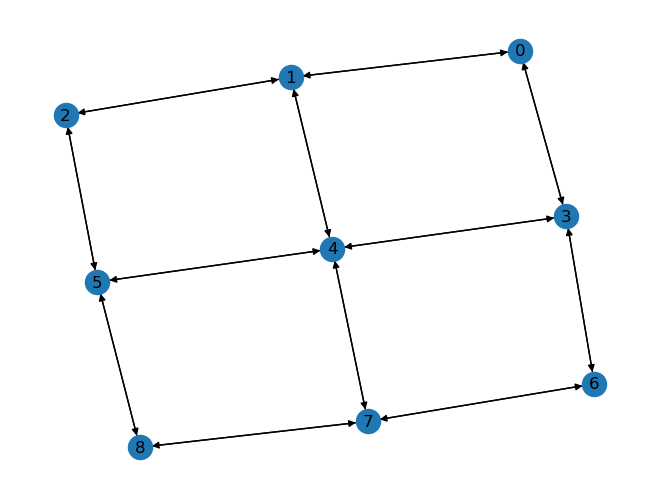

number of actions: 4
Sample trajectory:
tensor([[[6, 0, 3]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
action-to-node:
{1: tensor([5, 8]), 3: tensor([7, 8]), 2: tensor([8, 7]), 0: tensor([8, 5])}
node-to-action-matrix:
tensor([[-1,  3, -1,  1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1,  1, -1, -1, -1, -1],
        [-1,  2, -1, -1, -1,  1, -1, -1, -1],
        [ 0, -1, -1, -1,  3, -1,  1, -1, -1],
        [-1,  0, -1,  2, -1,  3, -1,  1, -1],
        [-1, -1,  0, -1,  2, -1, -1, -1,  1],
        [-1, -1, -1,  0, -1, -1, -1,  3, -1],
        [-1, -1, -1, -1,  0, -1,  2, -1,  3],
        [-1, -1, -1, -1, -1,  0, -1,  2, -1]])
affordance / node - to action:
{0: tensor([1, 3]), 1: tensor([1, 2, 3]), 2: tensor([1, 2]), 3: tensor([0, 1, 3]), 4: tensor([0, 1, 2, 3]), 5: tensor([0, 1, 2]), 6: tensor([0, 3]), 7: tensor([0, 2, 3]), 8: tensor([0, 2])}


In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML, sim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 500
random_feature_dim = 5000
epochs = 10

model = POCML(
    n_obs = env.n_items,
    n_states = env.size,
    n_actions = env.n_actions,
    state_dim = state_dim,
    random_feature_dim = random_feature_dim,
    alpha = 1,
    beta_obs = 8,
    beta_state = 8,
    memory_bypass=False,
    mem_reweight_rate = 0.0,#"adaptive", 
    decay = "adaptive"
)
    
trainer = POCMLTrainer(
    model=model, 
    train_loader = train_dataloader,
    lr_Q_o = 0.1, 
    lr_V_o = 0.01, 
    lr_Q_s = 0., 
    lr_V_s = 0., 
    lr_all = 1,
    normalize = False,
    reset_every=2,
    refactor_memory=True,
    debug=True
)

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Time 0
o_pre, o_next tensor(6) tensor(3)
Predicted obs from action tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.9896, 0.0013, 0.0013])
Predicted state before action (w hat): tensor([0.9488, 0.0070, 0.0058, 0.0074, 0.0063, 0.0050, 0.0072, 0.0058, 0.0067])
Predicted state after action (u hat): tensor([0.7263, 0.0356, 0.0330, 0.0364, 0.0278, 0.0343, 0.0358, 0.0352, 0.0355])
Predicted state from obs + memory (u tilde): tensor([0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111])
Current Trajectory tensor([[6, 0, 3]])
Print initial score tensor([0.0000, 0.0000, 0.0000, 4.6825, 0.0000, 0.0000, 8.0000, 0.0000, 0.0000])
Obs similarity based on memory (want close to identity)
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3541, 0.0

In [5]:
print("State similarities:\n", model.get_state_similarities())
print("Action similarities:\n", model.get_action_similarities())

State similarities:
 tensor([[ 2.4937e+01,  4.6415e-02, -8.8673e-02, -6.1376e-02,  2.9617e-01,
          3.9005e-01,  6.6620e-01, -2.7836e-02,  1.2523e-01],
        [ 4.6415e-02,  7.3996e-01, -6.4830e-02, -1.2970e-02,  5.5504e-03,
          2.8038e-02,  1.5716e-02,  1.8169e-02,  9.2918e-03],
        [-8.8673e-02, -6.4830e-02,  8.8427e-01,  2.1658e-02,  2.0632e-03,
          5.1829e-02, -2.2250e-02, -1.5380e-02,  5.1125e-02],
        [-6.1376e-02, -1.2970e-02,  2.1658e-02,  7.2175e-01,  5.1937e-02,
         -6.0078e-02,  1.0090e-02, -3.2348e-02, -5.7070e-02],
        [ 2.9617e-01,  5.5504e-03,  2.0632e-03,  5.1937e-02,  7.5685e-01,
         -1.7760e-02,  3.2448e-02,  5.4992e-02, -1.6796e-02],
        [ 3.9005e-01,  2.8038e-02,  5.1829e-02, -6.0078e-02, -1.7760e-02,
          8.2784e-01,  7.2753e-03,  3.9915e-02,  4.3376e-02],
        [ 6.6620e-01,  1.5716e-02, -2.2250e-02,  1.0090e-02,  3.2448e-02,
          7.2753e-03,  7.7783e-01,  1.1694e-02, -5.4454e-03],
        [-2.7836e-02,  1.81

In [6]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q.T, phi_Q.T))
print("Action kernel similarities:\n", sim(phi_V.T, phi_V.T))

State kernel similarities:
 tensor([[ 1.0000e+00, -2.2026e-03, -1.9512e-04,  9.9984e-03,  2.1778e-02,
          1.2824e-02,  1.8106e-04,  1.0413e-02,  1.9844e-02],
        [-2.2026e-03,  1.0000e+00,  4.2423e-01,  4.8234e-01,  4.7804e-01,
          4.6209e-01,  4.7486e-01,  4.5743e-01,  4.4782e-01],
        [-1.9512e-04,  4.2423e-01,  1.0000e+00,  4.6622e-01,  4.4422e-01,
          4.3611e-01,  4.1153e-01,  4.0638e-01,  4.4646e-01],
        [ 9.9984e-03,  4.8234e-01,  4.6622e-01,  1.0000e+00,  5.0821e-01,
          4.2814e-01,  4.6197e-01,  4.4206e-01,  4.4252e-01],
        [ 2.1778e-02,  4.7804e-01,  4.4422e-01,  5.0821e-01,  1.0000e+00,
          4.3434e-01,  4.6807e-01,  4.6239e-01,  4.4559e-01],
        [ 1.2824e-02,  4.6209e-01,  4.3611e-01,  4.2814e-01,  4.3434e-01,
          1.0000e+00,  4.3016e-01,  4.3221e-01,  4.3720e-01],
        [ 1.8106e-04,  4.7486e-01,  4.1153e-01,  4.6197e-01,  4.6807e-01,
          4.3016e-01,  1.0000e+00,  4.3242e-01,  4.3101e-01],
        [ 1.0413e-02

In [ ]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model_12_12_1.ckpt")

In [7]:
import evaluate

# train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
# print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

# test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
# print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

State-action accuracy/confidence/distance ratio: 0.0 0.05173056636704132 1.2944119492387982


In [8]:
env.start_state_idx

6

In [9]:
sa_distance_ratios

[0.7216743980577738,
 1.0080340263318852,
 1.0074417251521335,
 1.486894436461218,
 1.2823667552710547,
 1.2692522479153696,
 1.2820177450013992,
 1.0366434241799682,
 1.6663486707155823,
 1.318997845859427,
 1.3329851946008797,
 1.3216792545006357,
 1.559579192208326,
 1.3223411747742686,
 1.351328863604982,
 1.2477895425343433,
 1.2545376385807316,
 1.349502765863963,
 1.4603224067858556,
 1.3762261291065476,
 1.2345298639174114,
 1.5604910521277657,
 1.3163961251485106,
 1.2985063030311235]

In [10]:
from sklearn.manifold import MDS

def visualize(distances, legend:str ="Node"):
    mds = MDS(n_components =2)
    positions = mds.fit_transform(distances)

    plt.figure(figsize=(8, 6))
    plt.scatter(positions[:, 0], positions[:, 1])

    # Optional: Annotate the points
    for i, (x, y) in enumerate(positions):
        plt.text(x, y, f'{legend} {i}', fontsize=12)

    plt.title('Graph Visualization using MDS')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


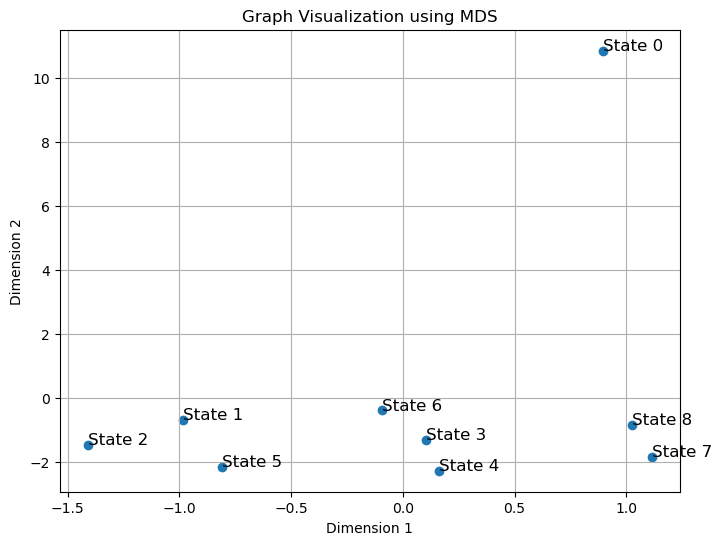

In [11]:
visualize(model.get_state_differences().numpy(), legend = "State")

In [ ]:
visualize(model.get_action_differences().numpy(), "Action")

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 